In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')
from scipy.signal import convolve2d

In [2]:
from oyla.mvc.utils import *


In [3]:
def rgbEqualizeHistogram(rgb):
    rgb = (rgb*255).astype('uint8')
    hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(hsv)
    _v = cv2.equalizeHist(v)
    hsv = cv2.merge((h,s,_v))
    ergb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    ergb[ergb>255] = 255
    ergb[ergb<0] = 0
    ergb = ergb.astype('float32')/255.0
    return ergb

In [4]:
sys.path.append('/Users/rsingh/Packages/MIT-intrinsic/')

In [5]:
from oyla.enhancement.homofilt import HomomorphicFilter

In [6]:
import poisson

In [7]:
def fit_reflectivity(x,y):
    reflectivity = {}
    reflectivity[100] = np.abs((y - 141201*np.power(x,-0.492)))
    reflectivity[80] = np.abs((y - 127047*np.power(x,-0.492)))
    reflectivity[50] = np.abs((y -100914*np.power(x,-0.493)))
    reflectivity[40] = np.abs((y - 91162*np.power(x,-0.494)))
    reflectivity[30] = np.abs((y - 81028*np.power(x,-0.498)))
    reflectivity[20] = np.abs((y - 65038*np.power(x,-0.495)))
    reflectivity[10] = np.abs((y - 46883*np.power(x,-0.498)))
    reflectivity[5] = np.abs((y - 33722*np.power(x,-0.501)))
    #print(np.min(reflectivity.values()))
    return reflectivity

In [8]:
def retinex(image,threshold):
    #image = v
    mask = np.ones_like(image)

    log_image = np.where(mask, np.log(image), 0.)
    i_y, i_x = poisson.get_gradients(log_image)

    r_y = np.where(np.abs(i_y) > threshold, i_y, 0.)
    r_x = np.where(np.abs(i_x) > threshold, i_x, 0.)

    log_refl = poisson.solve(r_y, r_x, mask)
    refl = np.exp(log_refl)
    return image/refl,refl

In [9]:
def fit_reflectivity2(ampl,phase):
    #reflectivity = phase*phase*np.power(ampl,0.986)/(2.1*np.power(10,10))
    reflectivity = phase*phase*np.power(ampl,0.996)/(5.63*np.power(10,10))
    return reflectivity

In [10]:
homo_filter = HomomorphicFilter(a=0.8, b = 1.2)

In [11]:
print(fit_reflectivity2(1608,13472.0))
print(fit_reflectivity(1608,13472.0))

5.032880905620126
{100: 9736.531843202107, 80: 10110.97548234997, 50: 10821.960172177778, 40: 11095.660217418666, 30: 11421.288016285303, 20: 11789.110558310496, 10: 12285.45300473298, 5: 12637.235414957835}


In [135]:
dir_path='/Users/rsingh/Data//44x33/oyla_1_camera_v2/08_Feb_data_February_08_05_41_43/filtered_data_February_22_05_04_24_median_3_9_edge_100//'

In [137]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)
filter_params = {}
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

reflectivity_thresh=0

In [138]:
filter_params = {}
filter_parameters = {}
filter_parameters['filter_cmd'] = {}
filter_parameters = read_csv_parameters("/Users/rsingh/Oyla/Work/our_python_dev/oyla/mvc/filter_params.csv")
for k in filter_parameters['filter_cmd'].keys():
        #print(parameters['filter_cmd'][k][self.epoch_number])
        try:
                filter_params[k] = int(filter_parameters['filter_cmd'][k][0])
                #parameters['filter_cmd'][k][0] = filter_parameters['filter_cmd'][k][0]
        except ValueError:
                pass
filter_params = {}

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [140]:
index = np.random.randint(0,500)
index = 502
#index = 214
print(index)
data = scipy.io.loadmat(dir_path+'/data_filtered_'+str(index)+'.mat')['data']
data2 = scipy.io.loadmat(dir_path+'/data_filtered_'+str(index+1)+'.mat')['data']
rgb = data2[0][4]
raw_phase = data[0][2][0][0][:,:,0]
raw_ampl = data[0][2][0][0][:,:,1]
rgb,raw_phase,raw_ampl = camera_calibrations(rgb,depth=raw_phase,ampl=raw_ampl,camera_version='oyla_1_camera_v2')
#_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)

filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                            range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                            filter_params = filter_params, ambiguity_distance = ambiguity_distance)
#filtered_phase = np.rot90(filtered_phase)
#thresholded_ampl = np.rot90(thresholded_ampl)
_filtered_phase = filtered_phase.astype('float32')/np.max(filtered_phase)
_thresholded_ampl = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)
_rgb = cv2.resize(rgb,(_filtered_phase.shape[1],_filtered_phase.shape[0]))
_rgb = _rgb.astype('float32')/255.0


502


In [142]:
raw_phase.shape

(200, 286)

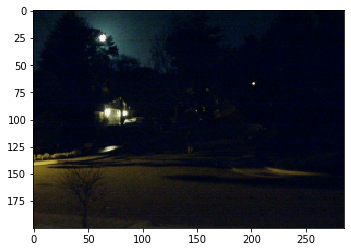

In [118]:
plt.imshow(_rgb)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


Text(0, 0.5, 'Phase')

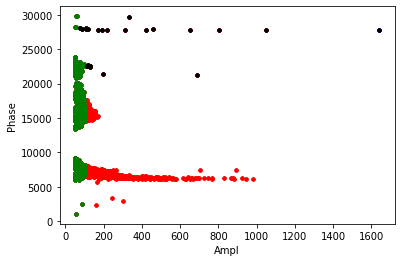

In [119]:
plt.plot(thresholded_ampl[(thresholded_ampl>1500)&(filtered_phase>0)],filtered_phase[(thresholded_ampl>1500)&(filtered_phase>0)],'b.')
plt.plot(thresholded_ampl[(thresholded_ampl<=1500)&(filtered_phase>0)],filtered_phase[(thresholded_ampl<=1500)&(filtered_phase>0)],'r.')
plt.plot(thresholded_ampl[(thresholded_ampl<=100)&(filtered_phase>0)],filtered_phase[(thresholded_ampl<=100)&(filtered_phase>0)],'g.')
hundred_reflectivity_dist = 234923*np.power(thresholded_ampl,-0.497)
plt.plot(thresholded_ampl[(filtered_phase>hundred_reflectivity_dist)],filtered_phase[(filtered_phase>hundred_reflectivity_dist)],'k.')

plt.xlabel('Ampl')
plt.ylabel('Phase')

In [120]:
rgb = rgb.astype('float32')/255.0
hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv)

In [121]:
rgb_illum,rgb_refl = homo_filter.get_illumination_reflectance(I=v,filter_params=[30,2])
_rgb_refl = cv2.resize(rgb_refl,(_filtered_phase.shape[1],_filtered_phase.shape[0]))
#_rgb_refl = _rgb_refl.astype('float32')/255.0

1.5653965733873816


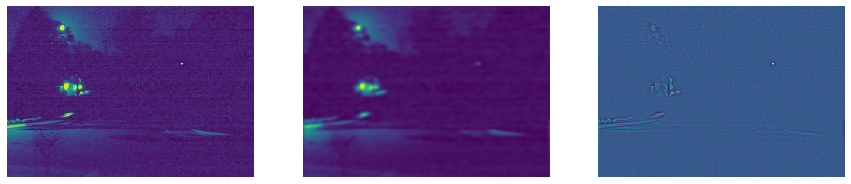

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
ax[1].imshow(rgb_illum)
ax[1].axis('off')
ax[2].imshow(rgb_refl)
ax[2].axis('off')
ax[0].imshow(v)
ax[0].axis('off')
print(np.max(rgb_refl))

In [123]:
oyla_refl = fit_reflectivity2(thresholded_ampl,filtered_phase)

0.0 1.0


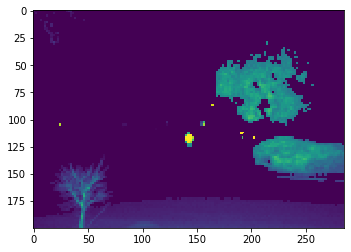

In [124]:
#print(indices['amplitude_saturated'])
oyla_refl_saturated = np.array(oyla_refl)
#oyla_refl_saturated[indices['amplitude_saturated']] = 1
for i in range(indices['amplitude_saturated'][0].shape[0]):
    x = indices['amplitude_saturated'][0][i]
    y = indices['amplitude_saturated'][1][i]
    sx = np.max([x-3,0])
    sy = np.max([y-3,0])
    ex = np.min([x+3,oyla_refl.shape[0]])
    ey = np.min([y+3,oyla_refl.shape[1]])
    #print(oyla_refl_saturated[sx:ex,sy:ey])
    oyla_refl_saturated[sx:ex,sy:ey] = 0
    #print(oyal_refl_saturated[sx:ex,sy:ey])
oyla_refl_saturated[oyla_refl_saturated>2] = 0
oyla_refl_saturated[oyla_refl_saturated>1] = 1

#oyla_refl_saturated = oyla_refl_saturated/np.max(oyla_refl_saturated)
plt.imshow(oyla_refl_saturated)
m = np.max(_rgb_refl)
refl = _rgb_refl.copy()

m = 1
mi = np.min(_rgb_refl)
ma = np.max(_rgb_refl)
refl = (refl-mi)/(ma-mi)

ind = np.where((refl/m<(oyla_refl_saturated)))
refl[ind] = (oyla_refl_saturated)[ind]*m
print(np.min(refl),np.max(refl))
refl = refl*(ma-mi)+mi

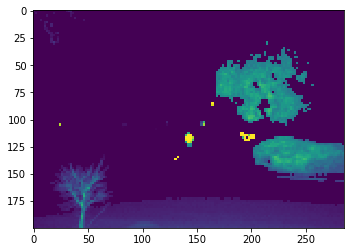

In [125]:
oyla_refl_original = np.array(oyla_refl)
oyla_refl_original[oyla_refl>2] = 0
oyla_refl_original[oyla_refl>1] = 1
plt.imshow(oyla_refl_original)

1


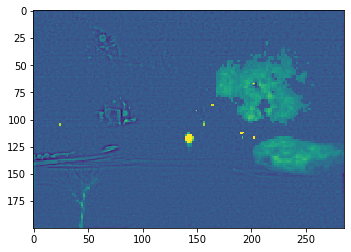

In [126]:
plt.imshow(refl)
print(m)
plt.imsave('/Users/rsingh/Downloads/test.png',refl)

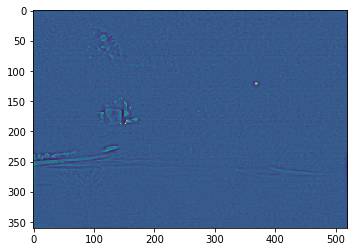

In [127]:
plt.imshow(rgb_refl)

Text(0, 0.5, 'counts')

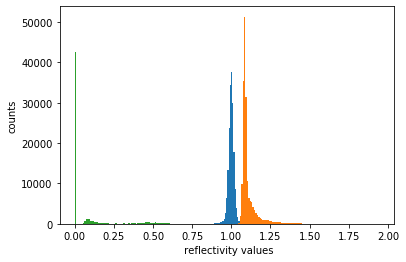

In [128]:
_=plt.hist(rgb_refl.reshape(-1),100)
_=plt.hist(rgb_illum.reshape(-1),100)
_=plt.hist(oyla_refl_saturated.reshape(-1),100)
#_=plt.hist(oyla_refl_illum.reshape(-1),100)
plt.xlabel(' reflectivity values')
plt.ylabel('counts')


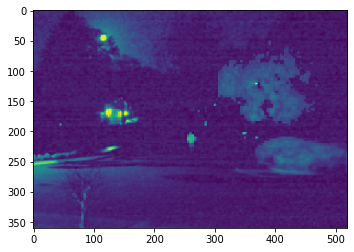

In [129]:
#_v = np.exp(np.log(illum)+np.log((refl)))
refl = cv2.resize(refl,(rgb_refl.shape[1],rgb_refl.shape[0]))
_v = rgb_illum*refl -1
#__v = (_v/np.max(_v)*255).astype('uint8')
#__v = cv2.equalizeHist(__v)
_v[_v>1]=1
plt.imshow(_v)
#plt.imsave('/Users/rsingh/Downloads/test2.png',_v)

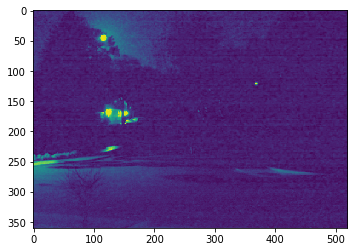

In [130]:
plt.imshow(v)
#plt.imsave('/Users/rsingh/Downloads/test5.png',v)
#np.min(v)

In [131]:
_v = _v.astype('float32')
_v[_v>1] = 1

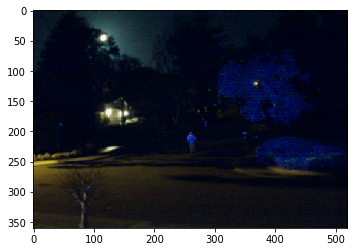

In [132]:
ehsv = cv2.merge((h,s,_v))
ergb = cv2.cvtColor(ehsv,cv2.COLOR_HSV2RGB)
ergb[ergb>1] = 1
ergb[ergb<0] = 0
plt.imshow(ergb)


In [54]:
ergb.shape

(360, 520, 3)

In [107]:
oyla_refl_illum,oyla_refl_refl = homo_filter.get_illumination_reflectance(I=oyla_refl_original,filter_params=[1,2])

1.5191199361518521 1.912197802453119


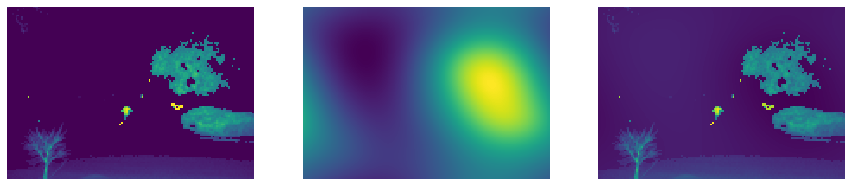

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
ax[1].imshow(oyla_refl_illum)
ax[1].axis('off')
ax[2].imshow(oyla_refl_refl)
ax[2].axis('off')
ax[0].imshow(oyla_refl_original)
ax[0].axis('off')
print(np.max(rgb_refl),np.max(oyla_refl_refl))

In [109]:
plt.imsave('/Users/rsingh/Downloads/test.png',oyla_refl_refl)

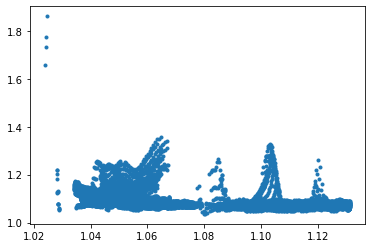

In [110]:
plt.plot(oyla_refl_illum[oyla_refl>0],rgb_illum[oyla_refl>0],'.')

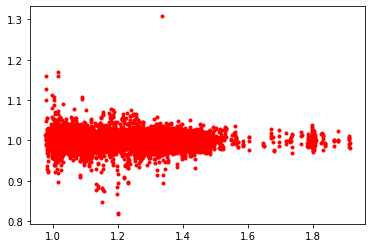

In [111]:
plt.plot(oyla_refl_refl[oyla_refl>0],rgb_refl[oyla_refl>0],'r.')

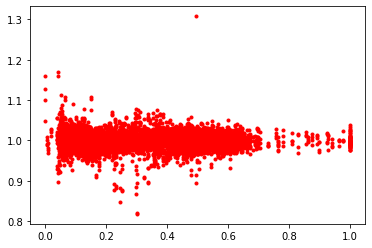

In [112]:
plt.plot(oyla_refl_original[oyla_refl>0],rgb_refl[oyla_refl>0],'r.')

In [113]:
m = 1

refl = rgb_refl.copy()
# mi = np.min(rgb_refl)
# ma = np.max(rgb_refl)
# refl = (refl-mi)/(ma-mi)

ind = np.where((refl/m<(oyla_refl_refl)))
refl[ind] = (oyla_refl_refl)[ind]*m
print(np.min(refl),np.max(refl))
#refl = refl*(ma-mi)+mi

0.9137456992450244 1.912197802453119


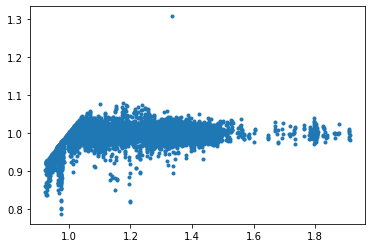

In [114]:
plt.plot(oyla_refl_refl[ind],rgb_refl[ind],'.')

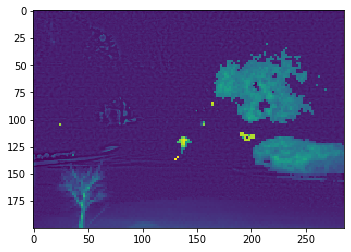

In [115]:
plt.imshow(refl)
plt.imsave('/Users/rsingh/Downloads/test.png',refl)

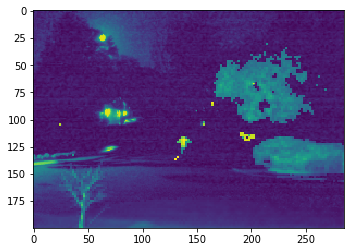

In [116]:
#_v = np.exp(np.log(illum)+np.log((refl)))
_v = rgb_illum*refl -1
#__v = (_v/np.max(_v)*255).astype('uint8')
#__v = cv2.equalizeHist(__v)
_v[_v>1]=1
plt.imshow(_v)
#plt.imsave('/Users/rsingh/Downloads/test2.png',_v)

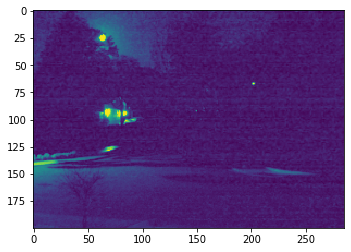

In [117]:
plt.imshow(v)
#plt.imsave('/Users/rsingh/Downloads/test5.png',v)
#np.min(v)

In [118]:
_v = _v.astype('float32')
_v[_v>1] = 1

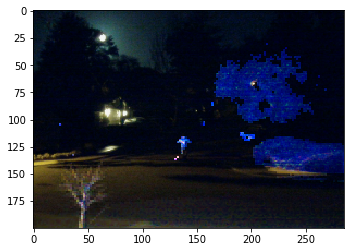

In [119]:
ehsv = cv2.merge((h,s,_v))
ergb = cv2.cvtColor(ehsv,cv2.COLOR_HSV2RGB)
ergb[ergb>1] = 1
ergb[ergb<0] = 0
plt.imshow(ergb)


In [52]:
np.max(_rgb)

1.0

illum2, refl2 = retinex(v,1)

f, axs = plt.subplots(4,1,figsize=(15,15))
axs[0].imshow(illum)
axs[0].axis('off')
axs[1].imshow(illum2)
axs[1].axis('off')
axs[2].imshow(refl/np.max(refl))
axs[2].axis('off')
axs[3].imshow(refl2/np.max(refl2))
axs[3].axis('off')

oyla_refl = fit_reflectivity2(thresholded_ampl,filtered_phase)

#oyla_refl[oyla_refl>1]=1
#oyla_refl[oyla_refl<=1]=0
plt.imshow(oyla_refl)
print(np.max(oyla_refl))
print(np.where(oyla_refl>1)[0].shape)
print(np.max(thresholded_ampl),np.max(filtered_phase))
#residual3 = np.array(oyla_refl)
oyla_refl_original = np.array(oyla_refl)
oyla_refl_original[oyla_refl_original>2]=0
oyla_refl_original[oyla_refl_original>1]=1
plt.imshow((oyla_refl_original))
#plt.grid('on')
m = np.max(rgb_refl)
r = np.array(rgb_refl)
# r = r-np.min(rgb_refl)
# r = r/np.max(r)
ind = np.where((r/m<(oyla_refl_original)))
refl = r.copy()
refl[ind] = (oyla_refl_original)[ind]*m

plt.imshow(refl)
ind[0].shape

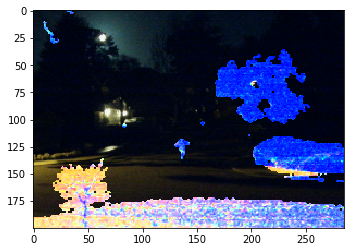

In [378]:
ind = np.where(oyla_refl>0)
s = np.max(_rgb,axis=2)
__rgb = _rgb.copy()
__rgb[ind] = _rgb[ind]*(1/s[ind])[:,np.newaxis]
plt.imshow(__rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


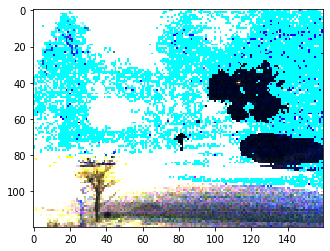

In [123]:
plt.imshow(_rgb/np.rot90(oyla_refl+0.00001)[:,:,np.newaxis])

0.9998955

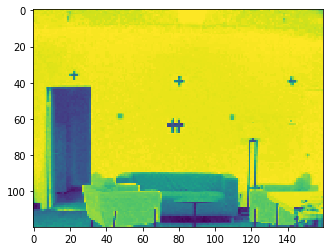

In [489]:
t = np.max(_rgb,axis=2)
r = np.mean(_rgb,axis=2)/(t+0.0001)
plt.imshow(r)
np.max(r)

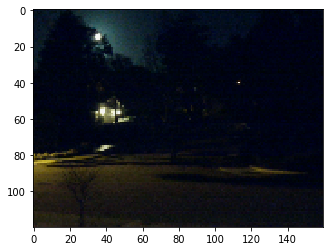

In [125]:
plt.imshow(_rgb)

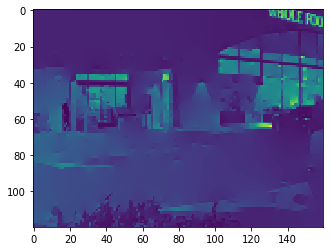

In [304]:
plt.imshow(np.exp(log_refl))
refl2 = np.exp(log_refl)

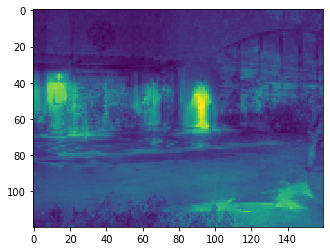

In [305]:
plt.imshow(image/refl2)
illum2 = image/refl2

In [14]:
r_rgb = plt.imread(dir_path+'/kitti/2d/intrinsic/oyla_'+str(index)+'-r.png')
s_rgb = plt.imread(dir_path+'/kitti/2d/intrinsic/oyla_'+str(index)+'-s.png')

In [230]:
import pyamg

il = cv2.ximgproc.guidedFilter(src=illum.astype('float32'),guide=oyla_refl.astype('float32'),radius = 15, eps = 0.00001)
#il = cv2.ximgproc.jointBilateralFilter(src=illum.astype('float32'),joint=oyla_refl.astype('float32'),d=-1,sigmaSpace=0.001,sigmaColor=1/1000)

(-0.5, 319.5, 119.5, -0.5)

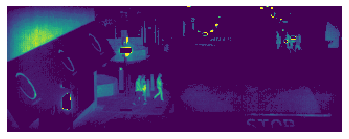

In [32]:
plt.imshow(((reflectivity)))
plt.axis("off")

In [18]:
I = r_rgb*s_rgb[:,:,np.newaxis]

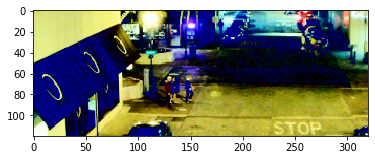

In [19]:
plt.imshow(rgbEqualizeHistogram(_rgb))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


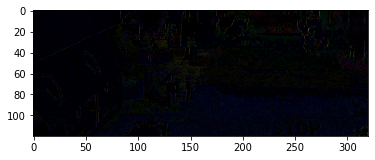

In [20]:
plt.imshow(rgbEqualizeHistogram(I)-rgbEqualizeHistogram(_rgb))

In [47]:
reflectivity = 0*thresholded_ampl.astype('float32')
for i in range(thresholded_ampl.shape[0]):
    for j in range(thresholded_ampl.shape[1]):
        a = thresholded_ampl[i,j]
        p = filtered_phase[i,j]
        if a>0:
            #r = fit_reflectivity(a,p)
            #m = min(r,key=r.get)
            #reflectivity[i,j] = m
            reflectivity[i,j] = fit_reflectivity2(a,p)

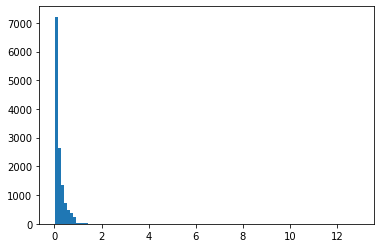

In [48]:
_=plt.hist(reflectivity[reflectivity>0],100)

In [49]:
np.max(reflectivity)

12.92241

In [53]:
#np.where(reflectivity>11)
#print(thresholded_ampl[1,253],filtered_phase[1,253])
reflectivity[reflectivity>1] = 1

(-0.5, 564.5, 211.5, -0.5)

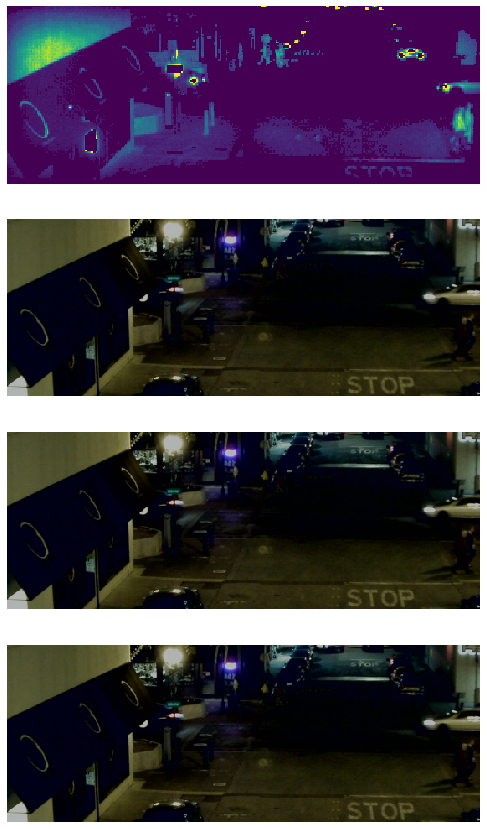

In [55]:
f, axs = plt.subplots(4,1,figsize=(15,15))
axs[0].imshow(np.transpose(reflectivity))
axs[0].axis('off')
axs[1].imshow(rgb)
axs[1].axis('off')
axs[2].imshow(rgb)
axs[2].axis('off')
axs[3].imshow(rgb)
axs[3].axis('off')

In [52]:
_reflectivity = reflectivity.astype('float32')

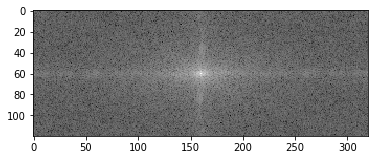

In [55]:
f = (np.fft.fft2(np.log(_reflectivity+0.0001)))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

In [26]:
shad = np.where(s_rgb>_reflectivity,s_rgb,_reflectivity)

(-0.5, 319.5, 119.5, -0.5)

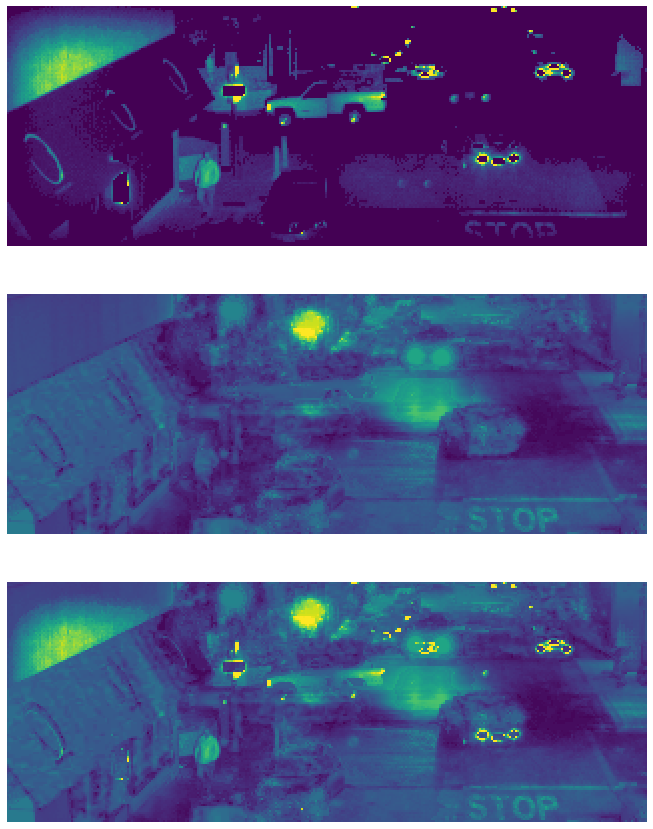

In [27]:
f, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].imshow((_reflectivity))
axs[0].axis('off')
axs[1].imshow(s_rgb)
axs[1].axis('off')
axs[2].imshow(shad)
axs[2].axis('off')

In [28]:
J = r_rgb*shad[:,:,np.newaxis]


(-0.5, 319.5, 119.5, -0.5)

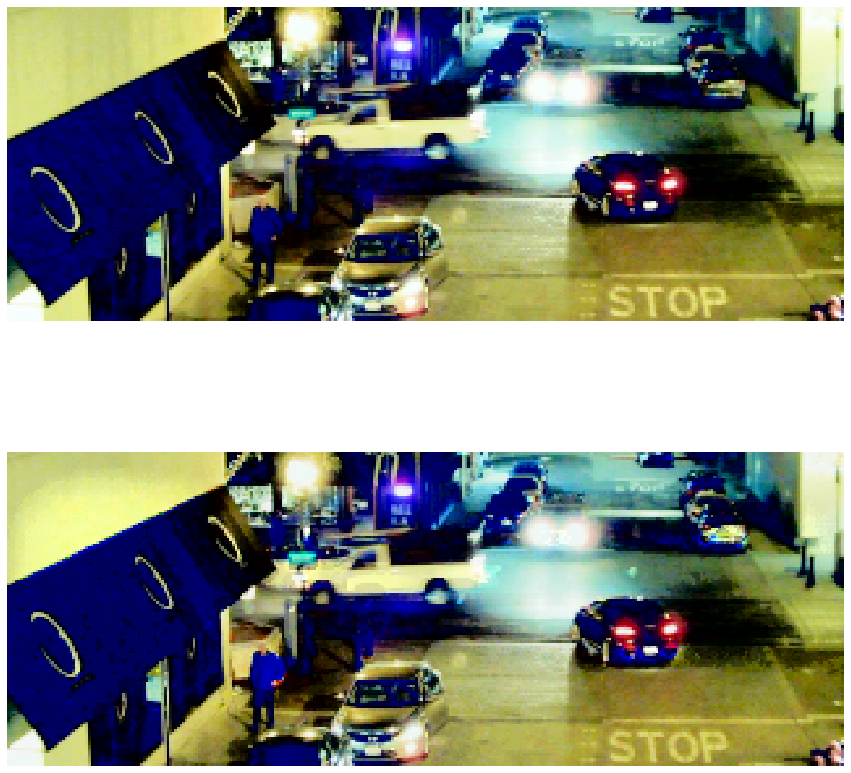

In [29]:
f, axs = plt.subplots(2,1,figsize=(15,15))
axs[0].imshow((rgbEqualizeHistogram(_rgb)))
axs[0].axis('off')
axs[1].imshow(rgbEqualizeHistogram(J))
axs[1].axis('off')


In [30]:
r_hsv = cv2.cvtColor(r_rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(r_hsv)

In [31]:
v[np.where(_reflectivity>v)] = _reflectivity[np.where(_reflectivity>v)]

In [32]:
er_hsv = cv2.merge((h,s,v))

In [33]:
er_rgb = cv2.cvtColor(er_hsv,cv2.COLOR_HSV2RGB)

(-0.5, 319.5, 119.5, -0.5)

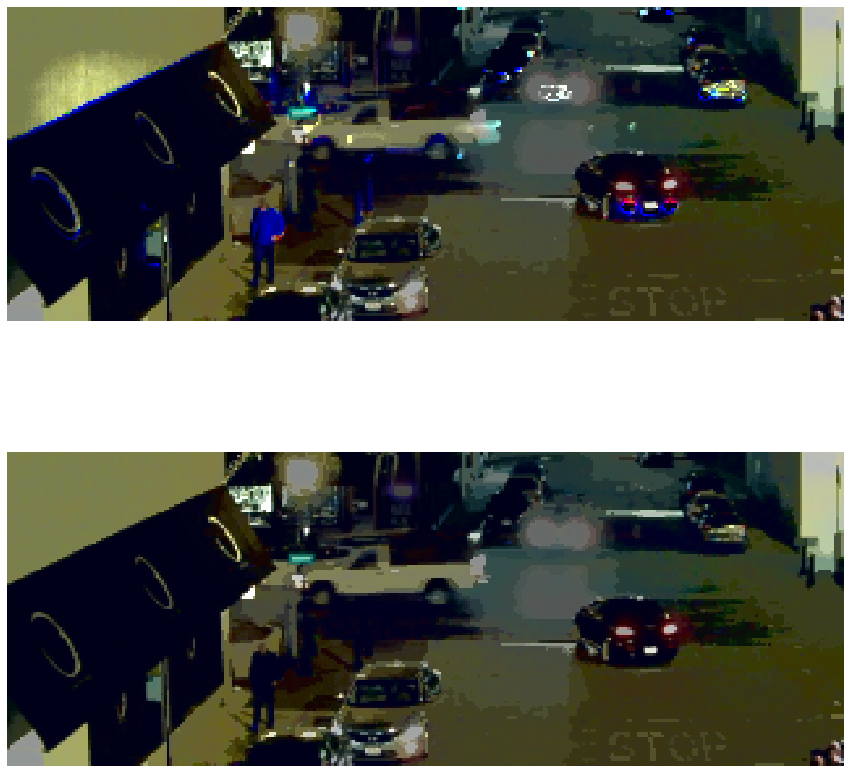

In [34]:
f, axs = plt.subplots(2,1,figsize=(15,15))
axs[0].imshow((er_rgb))
axs[0].axis('off')
axs[1].imshow(r_rgb)
axs[1].axis('off')

psf = cv2.getGaussianKernel(3,-1)
psf = np.matmul(psf,psf.transpose())

oyla_refl_clean = np.array(oyla_refl)
c = 0
ref_th = 1

while True:
    if np.count_nonzero(oyla_refl_clean>ref_th)>0:
        #print('x')
        c += 1
        source = np.zeros_like(oyla_refl)
        source[oyla_refl_clean>ref_th] = 1.0
        o = convolve2d(source,psf,mode='same')
        oyla_refl_clean = oyla_refl_clean*(1-o)
    else:
        break
print(c,np.max(oyla_refl_clean))
oyla_refl_clean[oyla_refl_clean>1] = 1
plt.imshow(oyla_refl_clean)


residual2 = np.array(oyla_refl)
c=0
while True:
    if np.max(residual2)>1:
        source = np.zeros_like(oyla_refl)
        source[np.unravel_index(np.argmax(residual2),residual2.shape)] = 1
        c += 1
        o = convolve2d(source,psf,mode='same')
        residual2 = residual2*(1-o)
    else:
        break
print(c,np.max(residual2))
plt.imshow(residual2)

_=plt.hist(residual[oyla_refl>0],100)
#_ = plt.hist(residual2[oyla_refl>1],100)
_=plt.hist(residual3[oyla_refl>0],100)

from skimage.util import view_as_windows
A = view_as_windows(oyla_refl,(3,3))
A.shape

plt.plot(oyla_refl[1:199,1:285].reshape(-1),np.mean(A,axis=(2,3)).reshape(-1),'.')
plt.plot(residual[1:199,1:285].reshape(-1),np.mean(A,axis=(2,3)).reshape(-1),'.')
plt.plot(oo[1:199,1:285].reshape(-1),np.mean(A,axis=(2,3)).reshape(-1),'.')

oo = oyla_refl[1:199,1:285]
plt.plot(oo[oo>0],np.mean(A,axis=(2,3))[oo>0],'.')
plt.grid('on')

B = np.zeros_like(oo)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        B[i,j] = np.sum(A[i,j])/(np.count_nonzero(A[i,j])+1)

plt.plot(oo[oo>1],B[oo>1],'.')
plt.grid('on')

m = np.max(rgb_illum)
ind = np.where((rgb_illum/m<(oyla_refl)))
illum = rgb_illum.copy()
illum[ind] = (oyla_refl)[ind]*m

oyla_refl_illum,oyla_refl_refl = homo_filter.get_illumination_reflectance(I=oyla_refl,filter_params=[10,2])

#oyla_refl_refl[oyla_refl_refl>1]=1
_=plt.hist(oyla_refl_refl.reshape(-1),100)
_=plt.hist(rgb_refl.reshape(-1),100)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(oyla_refl_illum)
ax[1].imshow(oyla_refl_refl)
np.count_nonzero(oyla_refl_refl>1)

m = np.max(rgb_refl)
ind = np.where((rgb_refl/m)<(oyla_refl_refl/np.max(oyla_refl_refl)))
refl = rgb_refl.copy()
refl[ind] = (oyla_refl_refl)[ind]*m

m = np.max(rgb_refl)
refl = rgb_refl.astype('float32')
base = cv2.bilateralFilter(refl,d=-1,sigmaColor=1,sigmaSpace=1)
details = refl-base
obase = cv2.bilateralFilter(oyla_refl.astype('float32'),d=-1,sigmaColor=1,sigmaSpace=1)
odetails = oyla_refl-obase
re = base+details+odetails*m

m = np.max(refl)
re = cv2.ximgproc.guidedFilter(src=refl.astype('float32')/m,guide=oyla_refl.astype('float32'),radius = 10, eps = 10)*m
#re = cv2.ximgproc.jointBilateralFilter(src=illum.astype('float32'),joint=oyla_refl.astype('float32'),d=-1,sigmaSpace=1,sigmaColor=0.1)

plt.imshow(details)

lv = np.log(v).astype('float32')
loy = np.log(oyla_refl+0.00001).astype('float32')
#_v = cv2.ximgproc.guidedFilter(src=lv,guide=loy,radius = 1, eps = 0.00001)
_v = lv+loy

plt.imshow(np.exp(_v))
_v = np.exp(_v)

In [35]:
K = er_rgb*s_rgb[:,:,np.newaxis]
#plt.imshow(rgbEqualizeHistogram(K))

(-0.5, 319.5, 119.5, -0.5)

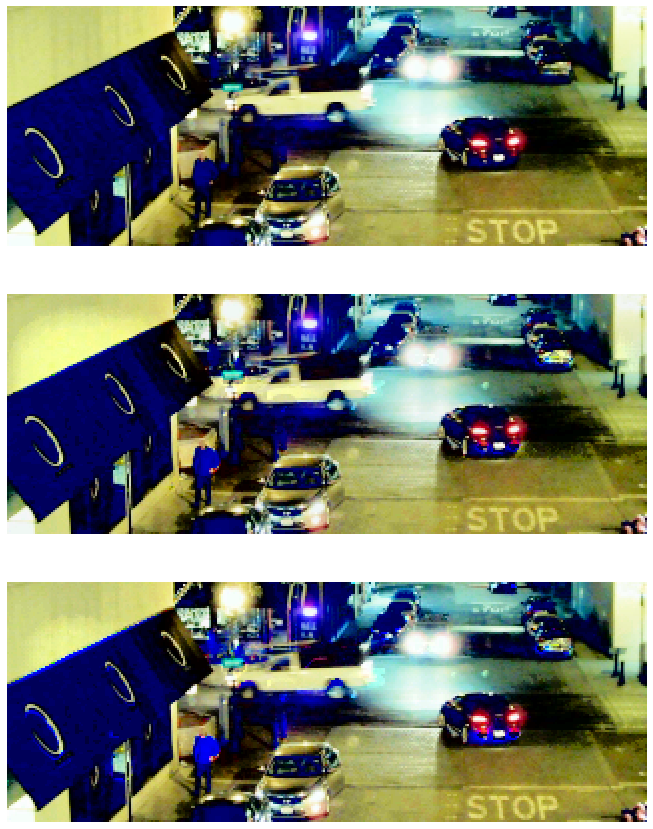

In [36]:
f, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].imshow(rgbEqualizeHistogram(_rgb))
axs[0].axis('off')
axs[1].imshow(rgbEqualizeHistogram(J))
axs[1].axis('off')
axs[2].imshow(rgbEqualizeHistogram(K))
axs[2].axis('off')

(-0.5, 319.5, 119.5, -0.5)

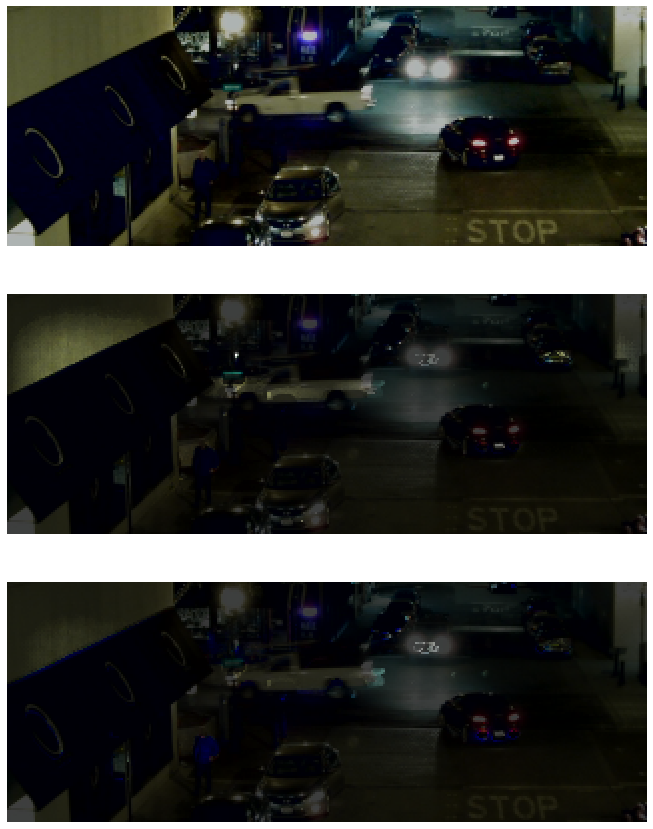

In [37]:
f, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].imshow((_rgb))
axs[0].axis('off')
axs[1].imshow((J))
axs[1].axis('off')
axs[2].imshow((K))
axs[2].axis('off')

In [53]:
r,g,b = cv2.split(_rgb)

In [54]:
np.max(reflectivity)

1.0

In [40]:
reflectivity.dtype

dtype('float32')

In [95]:
__rgb = _rgb

In [106]:
__rgb = np.concatenate((_rgb,_reflectivity[:,:,np.newaxis]),axis=2)

In [107]:
__rgb.shape

(120, 320, 4)

In [108]:
L = _rgb/(np.max(__rgb,axis=2)[:,:,np.newaxis]+0.00001)
L[L>1] = 1.0

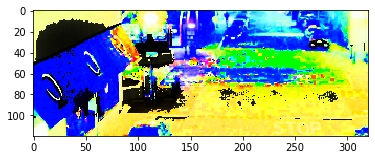

In [114]:
plt.imshow(rgbEqualizeHistogram(L))

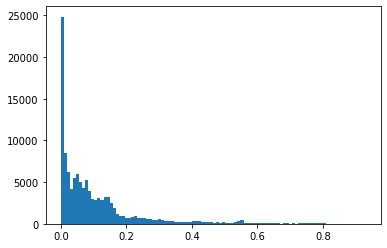

In [113]:
_=plt.hist(J.reshape(-1),100)